## The goal of this notebook is to demo use and shortfall of EKF for sine tracking
This is not a thourough analyis, only a demo

In [1]:
import numpy as np
from numpy import sin as npsin
from math import cos as npcos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, atan2, sin, cos, Equivalent, Equality, Derivative, Integral, Identity
from sympy import simplify, integrate, MatrixSymbol, inverse_laplace_transform, pi
from sympy.interactive import printing
printing.init_printing(use_latex=False,use_unicode=True)
%matplotlib notebook

<IPython.core.display.Javascript object>


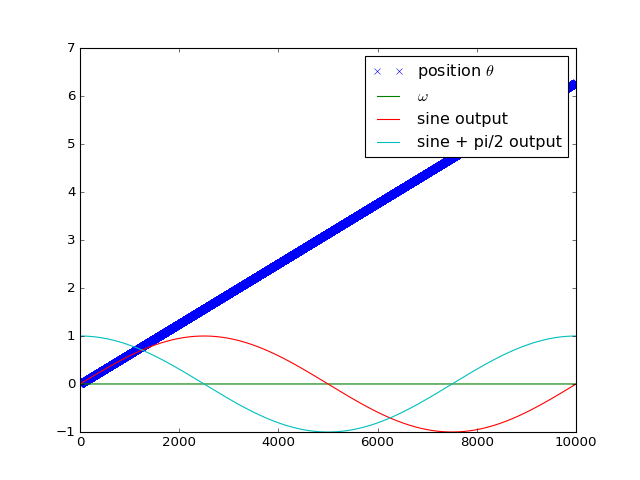

In [2]:
N = 10000
y=np.zeros([2,N])
q=np.zeros([2,N]) #[pos, speed]
y[:,0] = np.array([[0,np.pi / 5000]])
q[:,0] = np.array([[0,np.pi / 5000]])

phase_off_symbolic=pi/2
phase_off=np.float(phase_off_symbolic)



for i in range(1,N):
    prev = i-1
    y[0,i],y[1,i] = np.sin(y[1,prev])*prev, y[1,prev]
    q[0,i],q[1,i] = np.sin(q[1,prev])*prev, q[1,prev]
    
data = np.sin(y[0,:])
data2 = np.sin(q[0,:]+phase_off)

plt.figure()
plt.plot(y[0], 'x',label='position $\\theta$')    # position
plt.plot(y[1], label='$\omega$')                  # frequency
plt.plot(data, label='sine output')
plt.plot(data2, label='sine + pi/2 output')
plt.legend()

# Extended Kalman Filter Implementation for Trigonometric fitting

`[Wikipedia](http://en.wikipedia.org/wiki/Extended_Kalman_filter) writes: In the extended Kalman filter, the state transition and observation models need not be linear functions of the state but may instead be differentiable functions.

$\boldsymbol{x}_{k} = g(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the Jacobian matrix) is computed.

At each time step, the Jacobian is evaluated with current predicted states. These matrices can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.

In [3]:
A_1, A_2, A_3, A_4 = symbols('A_1 A_2 A_3 A_4')
theta_1, theta_2, theta_3, theta_4 = symbols('theta_1 theta_2 theta_3 theta_4')
omega_1, omega_2, omega_3, omega_4 = symbols('omega_1 omega_2 omega_3 omega_4')
y, t, tau, s = symbols('y, t, tau, s')
u_0, u_1, u_2 = symbols('u_0, u_1, u_2') # process noise
w_0, w_1, w_2 = symbols('w_0, w_1, w_2') # process noise
Phi, Phi_k = symbols('Phi Phi_k')        # dynamic continous or discrete function 
T_s = symbols('T_s',positive=True)       # for integration

# Formulation

In [4]:
y_rhs=A_1*sin(omega_1*t)
y_eq = Equality(y,y_rhs)
y_eq

y = A₁⋅sin(ω₁⋅t)

In [5]:
theta_eq = Equality(theta_1,omega_1*t)
theta_eq

θ₁ = ω₁⋅t

Frequency is constant

In [6]:
Equality(Derivative(theta_1,t),omega_1)

d          
──(θ₁) = ω₁
dt         

In [7]:
Equality(Derivative(omega_1,t),0)

d         
──(ω₁) = 0
dt        

Amplitude is constant

In [8]:
Equality(Derivative(A_1,t),0)

d         
──(A₁) = 0
dt        

## State Vector x

In [9]:
X = Matrix([theta_1,omega_1,A_1])
X

⎡θ₁⎤
⎢  ⎥
⎢ω₁⎥
⎢  ⎥
⎣A₁⎦

In [10]:
labels = X.applyfunc(lambda x:str(X)).tolist()[0][0]
numstates= X.shape[0]
numstates

3

## Dynamic Matrix

the next state x_k is the previous state plus some noise w

In [11]:
_F = np.zeros((3,3))
_F[0,1]=1
F = Matrix(_F)
F

⎡0.0  1.0  0.0⎤
⎢             ⎥
⎢0.0  0.0  0.0⎥
⎢             ⎥
⎣0.0  0.0  0.0⎦

In [12]:
u = Matrix([0,u_1,u_2])
u

⎡0 ⎤
⎢  ⎥
⎢u₁⎥
⎢  ⎥
⎣u₂⎦

In [13]:
dynamic_lhs = Derivative(X,t)
dynamic_rhs = F*X+u
dynamic_eq = Equality(dynamic_lhs,dynamic_rhs,evaluate=False)
dynamic_eq

∂                  
──⎛⎡θ₁⎤⎞ = ⎡1.0⋅ω₁⎤
∂t⎜⎢  ⎥⎟   ⎢      ⎥
  ⎜⎢ω₁⎥⎟   ⎢  u₁  ⎥
  ⎜⎢  ⎥⎟   ⎢      ⎥
  ⎝⎣A₁⎦⎠   ⎣  u₂  ⎦

This formulas calculate how the state is evolving from one to the next time step

### Calculate the Jacobian of the Dynamic Matrix with respect to the state vector

no brainer, but formally since parameters are constant the trasistion matrix is the Identity matrix

In [14]:
I = np.eye(3)
_Phi = I+F*t
_Phi

⎡1.0  1.0⋅t   0 ⎤
⎢               ⎥
⎢ 0    1.0    0 ⎥
⎢               ⎥
⎣ 0     0    1.0⎦

## Discrete Dynamic Matrix

the next state x_k is the previous state plus some noise w

In [15]:
_Phi_k = inverse_laplace_transform((s*I-F)**-1,s,T_s)
_Phi_k

⎡1.0  1.0⋅Tₛ   0 ⎤
⎢                ⎥
⎢ 0    1.0     0 ⎥
⎢                ⎥
⎣ 0     0     1.0⎦

## Initial Uncertainty $P_0$

Initial State Covariance

[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]] (3, 3)


<IPython.core.display.Javascript object>


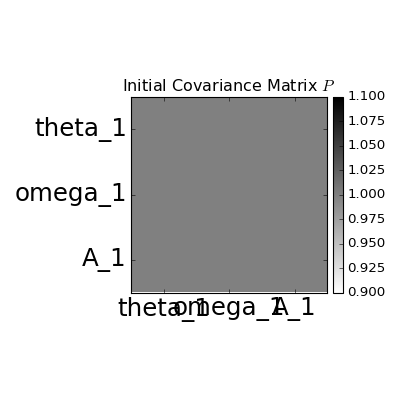

In [16]:
P = np.ones((numstates,numstates))
print(P, P.shape)

fig = plt.figure(figsize=(5, 5))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.yticks(np.arange(numstates),(labels), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.xticks(np.arange(numstates),(labels), fontsize=22)

plt.xlim([-0.5,numstates-0.5])
plt.ylim([numstates-0.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Process Noise Covariance Matrix Q

"*The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.*" - Kelly, A. (1994).

In [17]:
Q = Matrix(np.diag([0,w_1,w_2]))
Q

⎡0  0   0 ⎤
⎢         ⎥
⎢0  w₁  0 ⎥
⎢         ⎥
⎣0  0   w₂⎦

In [18]:
_Phi_mat = MatrixSymbol("Phi",3,3)
_Q = MatrixSymbol("Q",3,3)
Integral(_Phi_mat*_Q*_Phi_mat.T,[tau,0,T_s])

Tₛ          
⌠           
⎮       T   
⎮  Φ⋅Q⋅Φ  dτ
⌡           
0           

In [19]:
_Q_k = integrate(_Phi.subs({'t':tau})*Q*_Phi.T.subs({'t':tau}),[tau,0,T_s])
_Q_k

⎡                    3           2              ⎤
⎢0.333333333333333⋅Tₛ ⋅w₁  0.5⋅Tₛ ⋅w₁      0    ⎥
⎢                                               ⎥
⎢             2                                 ⎥
⎢       0.5⋅Tₛ ⋅w₁         1.0⋅Tₛ⋅w₁       0    ⎥
⎢                                               ⎥
⎣           0                  0       1.0⋅Tₛ⋅w₂⎦

In [20]:
w1  =  1
w2  =  0.0001
Ts =  1

Q = np.array(_Q_k.subs({w_1:w1, w_2:w2, T_s:Ts}).tolist(),dtype='double')
print(Q, Q.shape)

[[  3.33333333e-01   5.00000000e-01   0.00000000e+00]
 [  5.00000000e-01   1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e-04]] (3, 3)


<IPython.core.display.Javascript object>


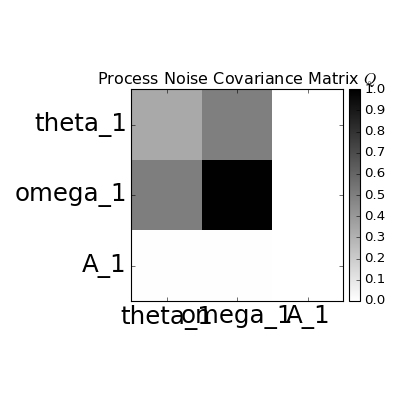

In [21]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.yticks(np.arange(numstates),(labels), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.xticks(np.arange(numstates),(labels), fontsize=22)

plt.xlim([-0.5,numstates-0.5])
plt.ylim([numstates-0.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Measurement Function H

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a measurement is available, the following function maps the state to the measurement.

In [22]:
y_rhs.subs({omega_1:theta_1/t})

A₁⋅sin(θ₁)

In [23]:
JH1_0=y_rhs.subs({omega_1:theta_1/t}).diff(theta_1)
JH1_0

A₁⋅cos(θ₁)

In [24]:
JH2_0=y_rhs.subs({omega_1:((theta_1+phase_off_symbolic)/t)}).diff(theta_1)
JH2_0 

-A₁⋅sin(θ₁)

In [25]:
JH1_1=y_rhs.subs({omega_1:theta_1/t}).diff(omega_1)
JH1_1

0

In [26]:
JH2_1=y_rhs.subs({omega_1:(theta_1+phase_off_symbolic)/t}).diff(omega_1)
JH2_1

0

In [27]:
JH1_2=y_rhs.subs({omega_1:theta_1/t}).diff(A_1)
JH1_2

sin(θ₁)

In [28]:
JH2_2=y_rhs.subs({omega_1:(theta_1+phase_off_symbolic)/t}).diff(A_1)
JH2_2

cos(θ₁)

In [29]:
JHs = Matrix([[JH1_0,JH1_1,JH1_2],[JH2_0,JH2_1,JH2_2]])
JHs

⎡A₁⋅cos(θ₁)   0  sin(θ₁)⎤
⎢                       ⎥
⎣-A₁⋅sin(θ₁)  0  cos(θ₁)⎦

In [30]:
ndim_obs = JHs.shape[0]
ndim_obs

2

If no measurement is available, simply set the corresponding values in $J_h$ to zero.

## Measurement Noise Covariance $R$

"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994).

In [48]:
R = np.matrix([0.001,0.001],dtype='double').T

print(R, R.shape)

[[ 0.001]
 [ 0.001]] (2, 1)


<IPython.core.display.Javascript object>


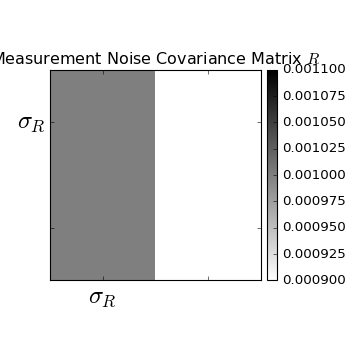

In [49]:
fig = plt.figure(figsize=(4.5, 4.5))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(ndim_obs+1))
# set the locations and labels of the yticks
plt.yticks(np.arange(ndim_obs),('$\sigma_R$',), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(ndim_obs+1))
# set the locations and labels of the yticks
plt.xticks(np.arange(ndim_obs),('$\sigma_R$',), fontsize=22)

plt.xlim([-0.5,ndim_obs-0.5])
plt.ylim([ndim_obs-0.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

$$x_k= \begin{bmatrix} theta \\ omega \\ A \end{bmatrix} = \begin{bmatrix} \text{position} \\ \text{velocity (rad/s)} \\ Amplitude \end{bmatrix} =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \end{matrix}}_{\textrm{Python Nomenclature}}$$

In [50]:
# simulate noise to the measurement
measurements = np.matrix(np.vstack([data+ np.random.normal(0,np.sqrt(R[0,0]),data.shape)  
                                    ,data2+np.random.normal(0,np.sqrt(R[1,0]),data2.shape)]))
m = measurements.shape[1]
m

10000

## Identity Matrix

In [51]:
print(I, I.shape)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]] (3, 3)


# Extended Kalman Filter

In [52]:
from sympy.utilities.lambdify import lambdify, implemented_function

dynamic_func = lambdify((theta_1,omega_1,A_1),(_Phi_k).subs({T_s:Ts})*X)
jacobian_func = lambdify((theta_1,omega_1,A_1),(_Phi_k.subs({T_s:Ts})*X).jacobian(X))
obs_func = lambdify((theta_1,omega_1,A_1,),JHs.subs({T_s:Ts}))

In [53]:
x = Matrix([0,1,1])
x.T.tolist()[0]

[0, 1, 1]

In [54]:
tof64 = lambda x:np.matrix(x.astype('float64'))

## Preallocation for Plotting
x0 = []
Z0 = []
Z1 = []
P0 = []
K0 = []
Y0 = []
meas_est0 = []

## Initial State
#x = Matrix([2,-1,-1/2 * np.pi / 500])
x = Matrix([0.1,np.pi / 5000,1])


for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    
    x =  dynamic_func(*x.T.tolist()[0]) #dynamic_func(x[0,0],x[1,0],x[2,0],x[3,0])
    x = tof64(x)

    JA = jacobian_func(*x.T.tolist()[0])
    
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Q    # M in KF10 slides then next HMAT*M
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = x
    
    JH = obs_func(*x.T.tolist()[0]) # has to be a row martix
    JH = tof64(JH)

    S = JH*P*JH.T + R
    S = tof64(S)

    
    K = (P*JH.T) * np.linalg.inv(S)
    K = tof64(K)
    
    # Update the estimate via
    Z = measurements[:,filterstep] 
     
    #y = Z - hx*JH                                # approximation of measurement
    meas_est = np.matrix([[(hx[2] * npsin(hx[0]))[0,0]],[hx[2] * npsin((hx[0]+phase_off))[0,0]]]) 
    y = Z - meas_est                              # Innovation or Residual if you can affford a sine
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*JH))*P

    # Save states for Plotting
    x0.append(x)
    Z0.append(Z)  
    P0.append(P)
    K0.append(K)
    Y0.append(y)
    meas_est0.append(meas_est)

## Plots

In [55]:
import pandas as pd

In [70]:
output = pd.concat([pd.DataFrame(np.hstack(x0).T,columns=['x0','x1','x2'])
                    ,pd.DataFrame(np.hstack(Y0).T,columns=['Y0','Y1'])
                    ,pd.DataFrame(measurements.T,columns=['Z0','Z1'])
                    ,pd.DataFrame(np.vstack([p.ravel() for p in P0]),columns=['P00','P01','P02','P10','P11','P12','P20','P21','P22'])
                    ,pd.DataFrame(np.vstack([k.ravel() for k in K0]),columns=['K00','K01','K10','K11','K20','K21'])
                    ,pd.DataFrame(np.hstack(meas_est0).T,columns=['meas_est0','meas_est1'])
                    ,pd.DataFrame(np.vstack([data,data2]).T,columns=['meas_ideal0','meas_ideal1'])
                    ],axis=1)

### Uncertainties

<IPython.core.display.Javascript object>


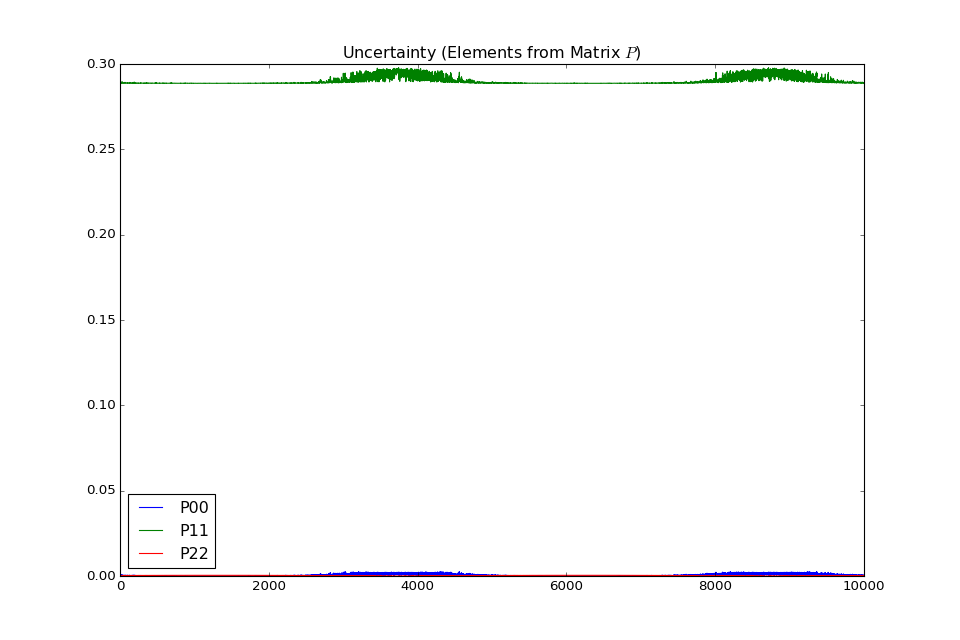

In [71]:
output.plot(y=['P00','P11','P22'],figsize=(12,8),title='Uncertainty (Elements from Matrix $P$)')

<IPython.core.display.Javascript object>


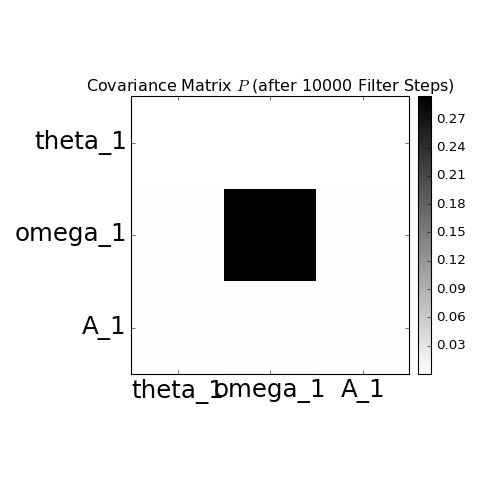

In [42]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.yticks(np.arange(numstates),(labels), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(numstates+1))
# set the locations and labels of the yticks
plt.xticks(np.arange(numstates),(labels), fontsize=22)

plt.xlim([-0.5,numstates-0.5])
plt.ylim([numstates-0.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Kalman Gains

<IPython.core.display.Javascript object>


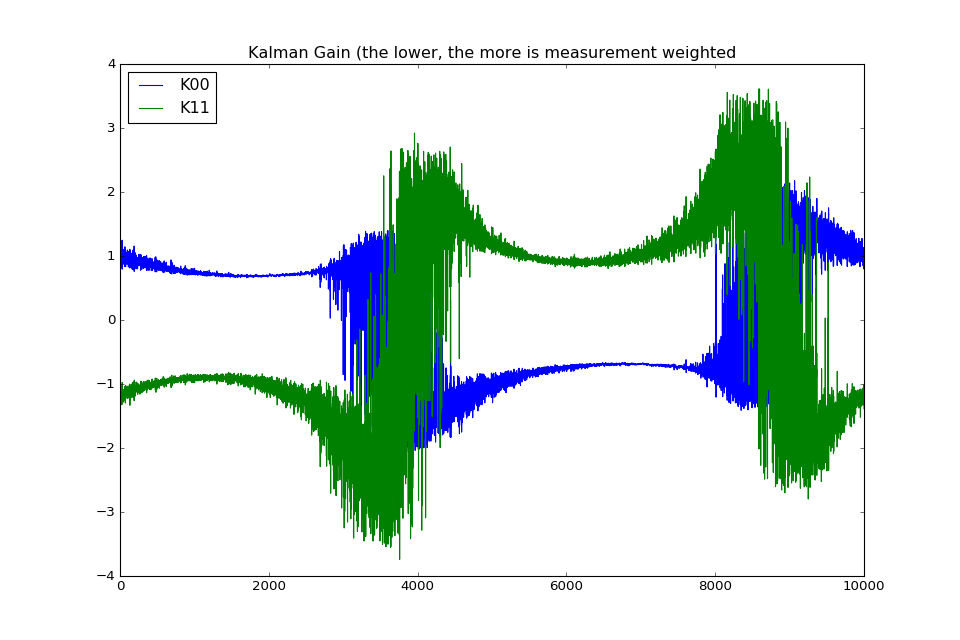

In [72]:
output.plot(y=['K00','K11'],figsize=(12,8),title='Kalman Gain (the lower, the more is measurement weighted')

## State Vector

$$x_k= \begin{bmatrix} theta \\ omega \\ A \end{bmatrix} = \begin{bmatrix} \text{position} \\ \text{velocity (rad/s)} \\ Amplitude \end{bmatrix} =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \end{matrix}}_{\textrm{Python Nomenclature}}$$

<IPython.core.display.Javascript object>


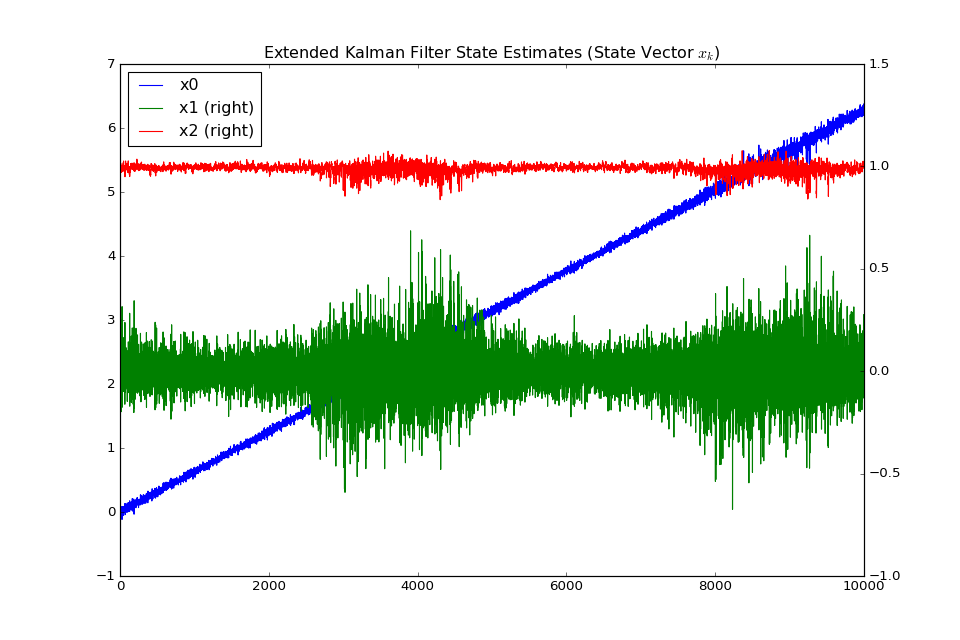

In [73]:
output.plot(y=['x0','x1','x2'],secondary_y=['x1','x2'],figsize=(12,8),title='Extended Kalman Filter State Estimates (State Vector $x_k$)')

<IPython.core.display.Javascript object>


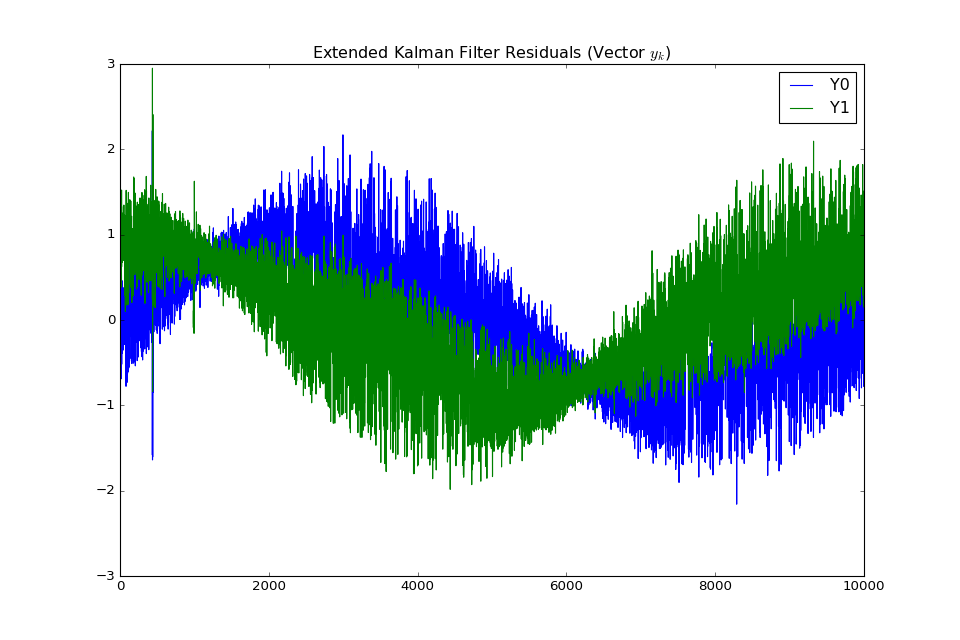

In [45]:
output.plot(y=['Y0','Y1'],figsize=(12,8),title='Extended Kalman Filter Residuals (Vector $y_k$)')

<IPython.core.display.Javascript object>


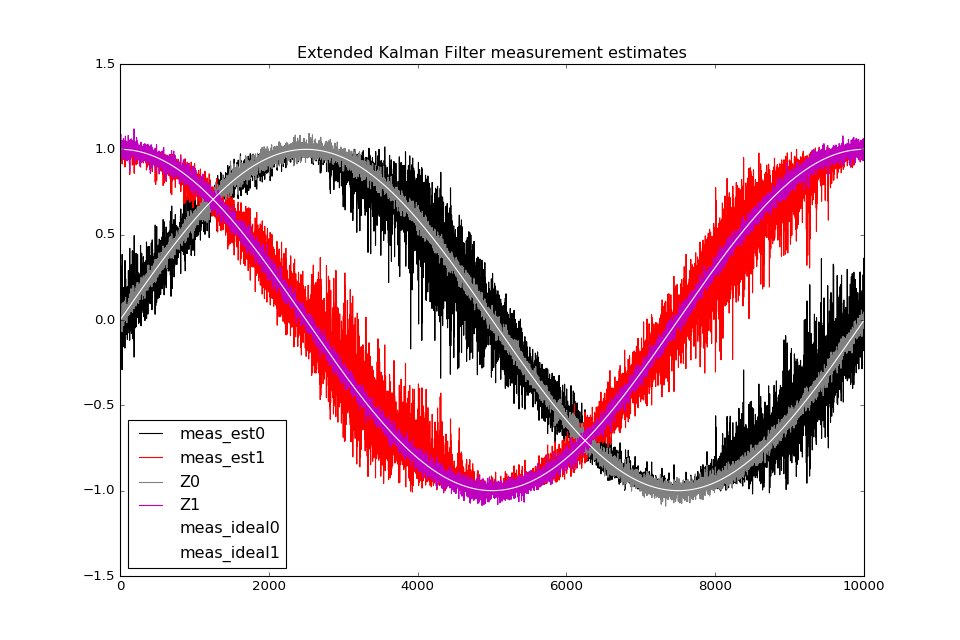

In [81]:
output.plot(y=['meas_est0','meas_est1','Z0','Z1','meas_ideal0','meas_ideal1'],style=['k','r','gray','m','w','w'],
            figsize=(12,8),title='Extended Kalman Filter measurement estimates')

# Conclusion

We can see that with the specific choice of transition matrix and measurement approximation function, we cannot stablise the residual near zero.
Also, the measurement approximation function is quite noisy.

# TODO
use holoview to plot nice graphic with sliders on the measurement noise
organise the notebook a little better
-comments are scattered in markdown text and in code comments, make them better
-measurement approx function could be in the measurement function and generated with a lambdidy
add a section on observability
add credit for people who did similar notebook and inspired this one